In [30]:
# import all the dependencies
from __future__ import division, print_function, absolute_import
import pandas as pd
from glob import glob
import fnmatch
import cv2
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from sklearn.utils import class_weight
#Import tflearn and some helpers
import tflearn
from tflearn.data_utils import shuffle
import os,sys,time,signal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import datetime as dt
import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d, avg_pool_2d
from tflearn.layers.normalization import local_response_normalization
from tflearn.layers.merge_ops import merge
from tflearn.layers.estimator import regression
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Sequential, model_from_json,load_model,Model
from tensorflow.keras import layers
from tensorflow.keras import Model


In [31]:
# 1)read data /the dataset has already been marked as class0=no cancer and class1=has cancer


image = glob( '../dataImg/*/**/*.png',recursive=True)
lowerIndex=0
upperIndex = len(image)
class0 = '*class0.png'
class1 = '*class1.png'
classZero = fnmatch.filter(image, class0)
classOne = fnmatch.filter(image, class1)

def process_images(lowerIndex,upperIndex):
	X = []
	Y = []
	WIDTH=50
	HEIGHT=50

	for img in image[lowerIndex:upperIndex]:
		full_size_image = cv2.imread(img)
		X.append(cv2.resize(full_size_image, (WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC))
		if img in classZero:
			Y.append(0)
		elif img in classOne:
			Y.append(1)
		else: 
			return
	return X, Y

X,Y = process_images(0,upperIndex)


df = pd.DataFrame(image)#load the dataset as a panda dataframe
df["images"]=X
df["lables"]=Y

X=np.array(X)


In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.2,  shuffle=True)

# # X_train = X_train.astype('float32')
# # X_test= X_test.astype('float32')

distribution=df['lables'].value_counts()
print(distribution)


0    4587
1     834
Name: lables, dtype: int64


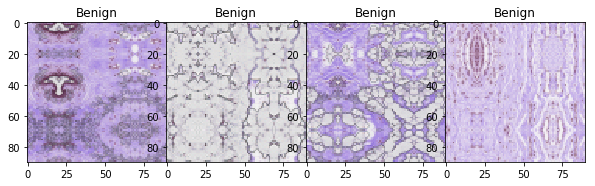

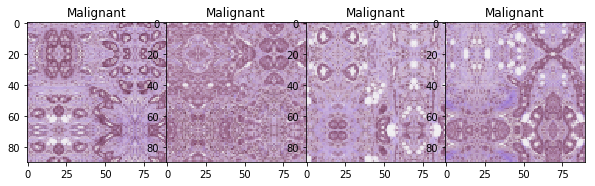

In [33]:
#plot some images
#plot test

plotImages=classZero
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in plotImages[:4]:
	im = cv2.imread(l)
	im = cv2.resize(im, (50, 50)) 
	color=[255,255,255]
	new_im = cv2.copyMakeBorder(im,20,20, 20,20, 20,
    value=color)
	plt.subplot(1, 4, i_+1).set_title("Benign")
	title="Benign"
	plt.imshow(new_im); plt.axis('on')
	i_ += 1
plt.show()

plotImages=classOne
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in plotImages[:4]:
	im = cv2.imread(l)
	im = cv2.resize(im, (50, 50)) 
	color=[255,255,255]
	new_im = cv2.copyMakeBorder(im,20,20, 20,20, 20,
    value=color)
	plt.subplot(1, 4, i_+1).set_title("Malignant")
	plt.imshow(new_im); plt.axis('on')
	i_ += 1
plt.show()



In [27]:
#Train models
img_input = layers.Input(shape=(50, 50, 3))

# First convolution extracts 16 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)

# Second convolution extracts 32 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Third convolution extracts 64 filters that are 3x3
# Convolution is followed by max-pooling layer with a 2x2 window
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)

# Flatten feature map to a 1-dim tensor so we can add fully connected layers
x = layers.Flatten()(x)

# Create a fully connected layer with ReLU activation and 512 hidden units
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Create output layer with a single node and sigmoid activation
output = layers.Dense(1, activation='sigmoid')(x)

# fc
model = Model(img_input, output)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 48, 48, 16)        448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 22, 22, 32)        4640      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 9, 9, 64)          18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 4, 4, 64)          0         
__________

In [34]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])
from tensorflow.keras.preprocessing.image import ImageDataGenerator


datagen = ImageDataGenerator(rotation_range=10,
                             width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                             height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                             horizontal_flip=True,  # randomly flip images
                             vertical_flip=False, # randomly flip images
                             rescale=1./255, # All images will be rescaled by 1./255
                             shear_range=0.1,
                             zoom_range=0.1
                             )  

#class_weigh = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)

history=model.fit_generator(datagen.flow(X_train, Y_train, batch_size=128),
                        steps_per_epoch=len(X_train)/32, epochs=15,# class_weight=class_weight,
                        verbose=1,
                        validation_steps=50, 
                        validation_data=[X_test, Y_test])


Epoch 1/15
136/135 [==============================] - 39s 285ms/step - loss: 0.1965 - acc: 0.9251 - val_loss: 2.4214 - val_acc: 0.8498
Epoch 2/15
136/135 [==============================] - 34s 249ms/step - loss: 0.1754 - acc: 0.9319 - val_loss: 2.3620 - val_acc: 0.8535
Epoch 3/15
136/135 [==============================] - 34s 250ms/step - loss: 0.1731 - acc: 0.9343 - val_loss: 2.4363 - val_acc: 0.8488
Epoch 4/15
136/135 [==============================] - 39s 287ms/step - loss: 0.1694 - acc: 0.9372 - val_loss: 2.4363 - val_acc: 0.8488
Epoch 5/15
136/135 [==============================] - 35s 258ms/step - loss: 0.1707 - acc: 0.9363 - val_loss: 2.3917 - val_acc: 0.8516
Epoch 6/15
136/135 [==============================] - 41s 303ms/step - loss: 0.1674 - acc: 0.9367 - val_loss: 2.2432 - val_acc: 0.8608
Epoch 7/15
136/135 [==============================] - 33s 243ms/step - loss: 0.1690 - acc: 0.9345 - val_loss: 2.4233 - val_acc: 0.8488
Epoch 8/15
136/135 [==============================] - 3

In [31]:

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(img_input, successive_outputs)

Text(0.5, 1.0, 'Training and validation loss')

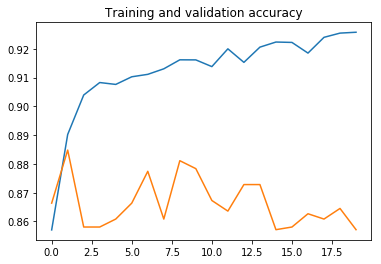

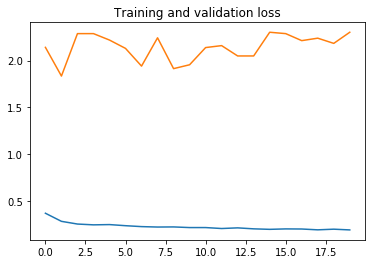

In [32]:

#Evaluating accuracy and loss for the model

# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title('Training and validation loss')


In [ ]:
#clean up

import os, signal
os.kill(os.getpid(), signal.SIGKILL)